In [1]:
# importing libraries 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import recall_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.svm import SVC
import pickle
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# importing dataset
df = pd.read_csv('diabetic_data.csv', na_values=['?'], low_memory=False)
# Printing the dataset shape
print(df.shape)
# Printng the column names
print(df.columns)

(101766, 50)
Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')


### 1.1 Data cleaning

#### Checking for redundant features

In [3]:
# Let us remove redundant entries from dataset
print(len(df['encounter_id'].unique()))
print(len(df['patient_nbr'].unique()))

101766
71518


Patients are the centre of our study. There are total of 101766 encounters and there are 71518 unique patients. Thus data contains mutiple entries for the same patient. Let's check if the 'readmitted' status for a patient with multiple visits stays the same. If yes, we can remove them and if not we can keep them and treat each encounter as an encounter of different patient.

In [4]:
duplicate = df[df.duplicated(['patient_nbr', 'readmitted'])]
print(duplicate.shape)

(13973, 50)


So, there are 13973 patients which have the same readmission status. This is redundant data. Let's drop those records. 

In [5]:
# dropping the duplicate rows and keeping the 'last' as they are the most recent ones
df.drop_duplicates(subset=['patient_nbr','readmitted'], keep='last', inplace=True)
print(df.shape)

(87793, 50)


In [6]:
# Print the number of unique values for each feature column
df.nunique()

encounter_id                87793
patient_nbr                 71518
race                            5
gender                          3
age                            10
weight                          9
admission_type_id               8
discharge_disposition_id       26
admission_source_id            17
time_in_hospital               14
payer_code                     17
medical_specialty              71
num_lab_procedures            118
num_procedures                  7
num_medications                75
number_outpatient              35
number_emergency               28
number_inpatient               18
diag_1                        707
diag_2                        733
diag_3                        778
number_diagnoses               16
max_glu_serum                   3
A1Cresult                       3
metformin                       4
repaglinide                     4
nateglinide                     4
chlorpropamide                  4
glimepiride                     4
acetohexamide 

As we can see, columns 'examide', 'glimepiride-pioglitazone' and 'citogliption' have only 1 unique value that means, all the values in those columns are same and have 0 variance and hence don't make any contribution towards finding any meaningful pattern in data.

In [7]:
df.loc[:5, ['examide', 'citoglipton', 'glimepiride-pioglitazone']]

,examide,citoglipton,glimepiride-pioglitazone
0,No,No,No
1,No,No,No
2,No,No,No
3,No,No,No
4,No,No,No
5,No,No,No


Columns 'examide', 'glimepiride-pioglitazone' and 'citoglipton' have only one unique value each and the value for 'examide' and 'glimepiride-pioglitazone' in all rows is 'No' which means, this drug was never prescibed to any patient. On similar lines, whether drug 'citogliption' was administered to patient is unknown. Therefore, all of these columns will be dropped. 

In [8]:
df["metformin-rosiglitazone"].value_counts()

metformin-rosiglitazone
No        87791
Steady        2
Name: count, dtype: int64

In [9]:
df["metformin-pioglitazone"].value_counts()

metformin-pioglitazone
No        87792
Steady        1
Name: count, dtype: int64

In [10]:
df['acetohexamide'].value_counts()

acetohexamide
No        87792
Steady        1
Name: count, dtype: int64

Columns "metformin-rosiglitazone", "metformin-pioglitazone" and 'acetohexamide' have 2 values each but the minority value has only 1 or 2 rows, which is not sufficient for ML model to find any useful pattern. Therefore these columns too will be dropped.

Columns 'encounter_id' and 'patient_nbr' serve no purpose in determining readmission status of patient as these are just identifiers for hospital visit and patient. Therefore, these two columns too will be dropped. 

In [11]:
# dropping columns 'examide','citogliption', 'encounter_id', 'patient_nbr'
df.drop(columns=['examide', 'citoglipton', 'glimepiride-pioglitazone', "metformin-rosiglitazone",
                 "metformin-pioglitazone", 'acetohexamide', 'encounter_id', 'patient_nbr'], inplace=True)
print(df.shape)

(87793, 42)


In [12]:
df['discharge_disposition_id'].unique()

array([25,  1,  3,  6,  2,  5, 11, 10,  7,  4, 14, 18,  8, 13, 12, 16, 22,
       17, 23,  9, 20, 15, 24, 28, 19, 27])

In [13]:
vals = [ 13,14,11,19,20,21]

In [14]:
df['readmitted'].value_counts()

readmitted
NO     54820
>30    24139
<30     8834
Name: count, dtype: int64

Referring to the mapping file which indicates what categories these numbers are mapped to, it shows that the numbers  11,19,20,21 indicate that the patient has expired, needless, to say, these patients will never be readmitted and therefore better to remove from the dataset. 

In [15]:
(df[df['discharge_disposition_id'].isin([11,19,20,21])]['readmitted']!= 'NO').sum()

0

In [16]:
# finding the index of records where dischare_disposition_id is in [13,14,11,19,20,21]
hospice_index = df[df['discharge_disposition_id'].isin([ 11,19,20,21]) ].index
# dropping all those records whose index is in hospice_index
df.drop(hospice_index, inplace = True) 
# printing shape for verifying if rows have been succesfully dropped
print(df.shape)

(86141, 42)


Feature 'gender' has 3 values, let's examine the number of value counts

In [17]:
df['gender'].value_counts()

gender
Female             46046
Male               40092
Unknown/Invalid        3
Name: count, dtype: int64

3 rows have gender values that are unknown/invalid. Let's remove those rows as they will unnecessarily lead to increase in number of dimensions without contributing toward predicting output variable

In [18]:
df.drop(df[df['gender']=='Unknown/Invalid'].index, inplace=True)

Values 18,25,26 values stand for 'Null', 'Not mapped', 'Unknown/Invalid'. We can therefore group them under under same category i.e. 26 i.e. Unknown/Invalid

In [19]:
df['discharge_disposition_id'] =df['discharge_disposition_id'].apply(lambda x : 26 if x in [18, 25] else x )

Similarly, for feature 'admission_source_id', 9,17,20 refer to 'unknown/invalid'. So let's group them under the same category i.e 15 for 'not available'

In [20]:
df['admission_source_id'] =df['admission_source_id'].apply(lambda x : 15 if x in [9,17,20,21] else x )

On similar lines, values 5,6 and 8 can be mapped to 5 for 'not available'

In [21]:
df['admission_type_id'] =df['admission_type_id'].apply(lambda x : 5 if x in [5,6,8] else x )

### 1.2 Data Preprocessing

#### Analysing feature 'age'

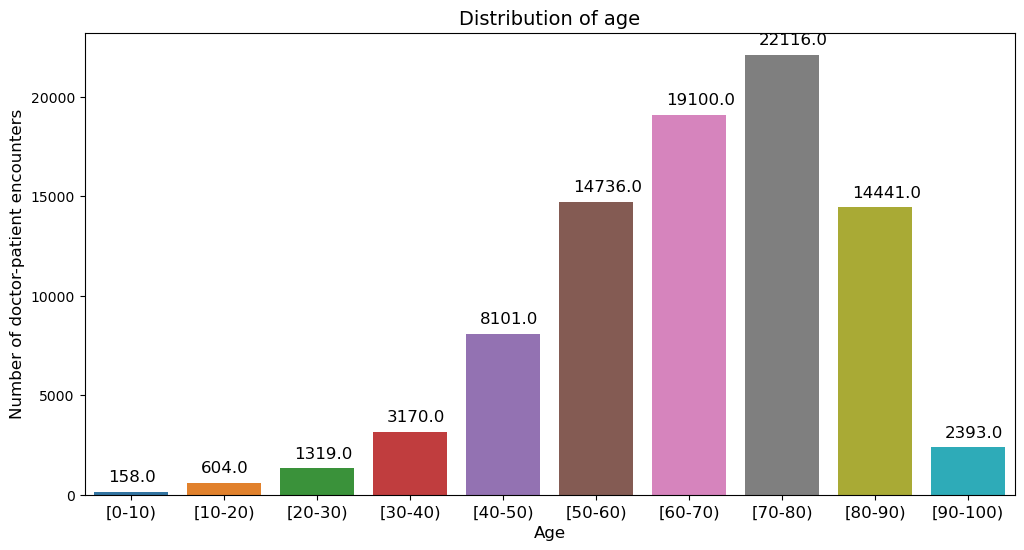

In [22]:
# plotting the count of different values in target variable 'readmitted'
plt.figure(figsize=(12,6))
ax = sns.countplot(x=df['age'])
plt.title('Distribution of age', fontsize=14)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Number of doctor-patient encounters', fontsize=12)
plt.xticks(fontsize=12)

total = len(df['age'])
for p in ax.patches:
    count = '{}'.format(p.get_height())
    x = p.get_x() + .15 
    y = p.get_y() + p.get_height() + 500
    ax.annotate(count, (x, y), fontsize=12)

plt.show()

Majority of patients are in the age group of 70-80 years.

#### Preprocessing feature 'age'

Age is a categorical variable here, as it is represented by buckets of age 10 each. This can be converted into integer by taking the median age of each class and denoting the whole class by one integer value. Like, age [0-10) will be denoted by 
(0+10)/2 = 5, [10-20) by 15, [20-30) by 25 and so on. 

In [23]:
df.loc[(df[df['age'] =='[0-10)'].index), 'age'] = 5
df.loc[(df[df['age'] =='[10-20)'].index), 'age'] = 15
df.loc[(df[df['age'] =='[20-30)'].index), 'age'] = 25
df.loc[(df[df['age'] =='[30-40)'].index), 'age'] = 35
df.loc[(df[df['age'] =='[40-50)'].index), 'age'] = 45
df.loc[(df[df['age'] =='[50-60)'].index), 'age'] = 55
df.loc[(df[df['age'] =='[60-70)'].index), 'age'] = 65
df.loc[(df[df['age'] =='[70-80)'].index), 'age'] = 75
df.loc[(df[df['age'] =='[80-90)'].index), 'age'] = 85
df.loc[(df[df['age'] =='[90-100)'].index), 'age'] = 95

#### Analysing target variable 'readmitted'

Our target variable is feature 'readmitted'. Before feature engineering, let's check if all features are relevant and if they will help in predicting the target variable

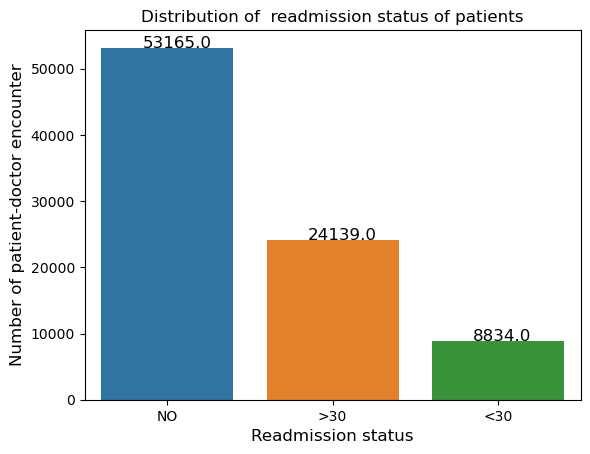

In [24]:
# plotting the count of different values in target variable 'readmitted'
ax = sns.countplot(x=df['readmitted'])
plt.title('Distribution of  readmission status of patients')
plt.xlabel('Readmission status', fontsize=12)
plt.ylabel('Number of patient-doctor encounter', fontsize=12)

for p in ax.patches:
    count = '{}'.format(p.get_height())
    x = p.get_x() + .25 
    y = p.get_y() + p.get_height() 
    ax.annotate(count, (x, y), fontsize=12)

plt.show()

As per our business problem, we need to find out if patient will be readmitted within 30 days or not. So we need to convert this into binary classification problem with 2 classes, i.e. patient readmitted before 30 days or not. So, here, we will change all rows with value '>30' to 0 denoting 'not readmitted in less than 30 days' and those with '<30' to '1' denoting 'yes readmitted in less than 30 days'. The rows with value 'NO' too will be converted to '0'. 

In [25]:
# Assigning values '0' and '1' for patients that weren't readmitted and those that were readmiited respectively
df['readmitted']=df['readmitted'].apply(lambda x : 1 if x == '<30' else 0 )
print(df['readmitted'].value_counts())

readmitted
0    77304
1     8834
Name: count, dtype: int64


Now we have a binary target variable with values '0' for non-readmission and '1' for readmission of patient.

### 1.3 Univariate Analysis 

#### 1.3.1 Univariate analysis of A1C test result

AttributeError: 'numpy.int64' object has no attribute 'startswith'

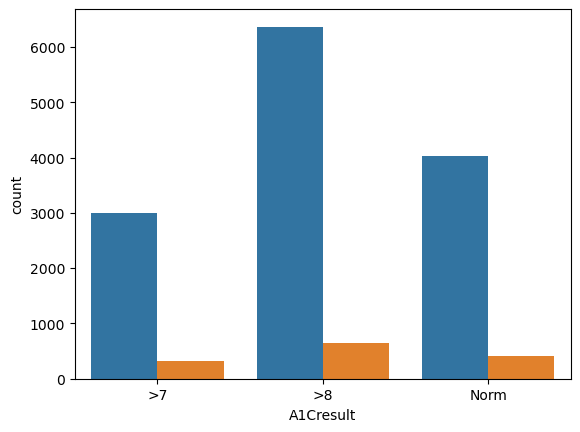

In [26]:
sns.countplot(x='A1Cresult', hue='readmitted', data=df)

From this graph it seems that, patients for whom A1C test was not conducted were readmitted unlike those whose A1C test was conducted ( and result was >7, >8 or Norm). This seems to be aligned with what we had found in research paper. 

However, we cannot ignore the fact that for a large number of patients, test was not conducted at all and so the proportion of patients who were readmitted seems high for those patients. But, as the number of patients for whom test was conducted is very small and  so corresponding number of not-readmitted patients too is small. This will be more clear from below graph. 

<Axes: xlabel='readmitted', ylabel='count'>

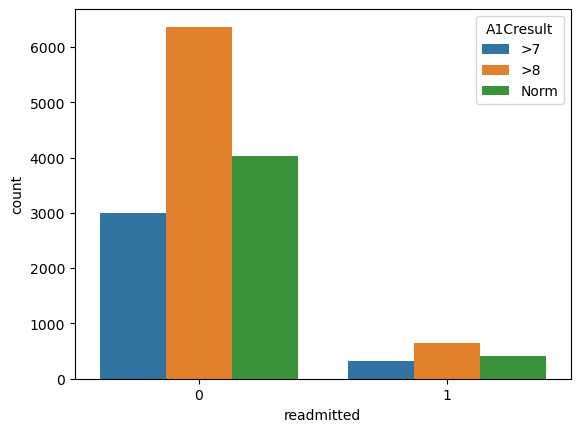

In [27]:
sns.countplot(x='readmitted', hue='A1Cresult', data=df)

Here, it is evident that, the proportion of patients whose test was conducted and those whose test was not conducted is almost the same. Let's go one step further to confirm our conclusion that A1C test does not have significant impact on 
determining the readmission status of patient as stated by the reference research papers. 

AttributeError: 'numpy.int64' object has no attribute 'startswith'

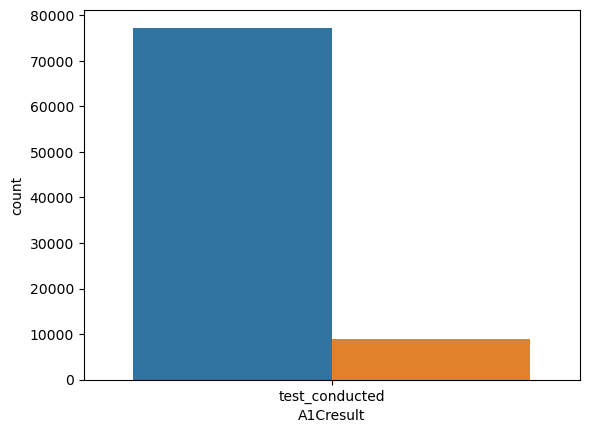

In [28]:
# Create a separate temporary dataframe to analyze whether conducting A1C test helps in determining readmission status
temp_df = df.loc[:, ['A1Cresult', 'readmitted']]
temp_df['A1Cresult'] = temp_df['A1Cresult'].apply(lambda x: 'test_not_conducted' if x == 'None' else 'test_conducted')

# Corrected countplot code
sns.countplot(x='A1Cresult', hue='readmitted', data=temp_df)

<b> Query : </b> <i> Is it true that patients whose A1C test was conducted are less susceptible to getting readmitted ?</i>
    
As seen from above graphs, the distribution of patients whose test was conducted and those whose test was not conducted is almost the same. Therefore, we can't conclude that conducting A1C test implies less chance of readmission.

#### 1.3.2 Univariate analysis of num_lab_procedures

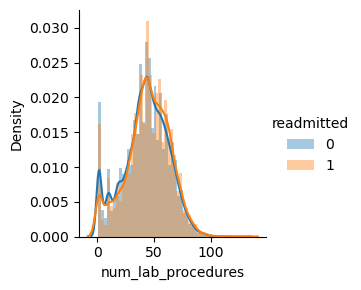

In [29]:
sns.FacetGrid(df,hue='readmitted').map(sns.distplot,'num_lab_procedures').add_legend()

In [30]:
mn = df['num_lab_procedures'].mean()
md = df['num_lab_procedures'].median()
print('mean and median of num_lab_procedures is {:.2f} and {:.2f} respectively'.format(mn,md))

mean and median of num_lab_procedures is 42.97 and 44.00 respectively


The distribution of number of lab procedures for both readmitted patients and non-readmitted patients is same but, as these features have considerable variation, they will prove to be useful for model to find patterns in overall complete training data.

Text(0.5, 1.0, 'PMF of num_lab_procedures')

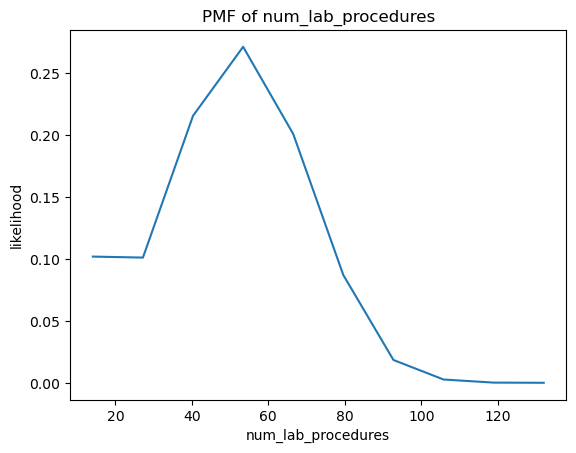

In [31]:
counts, bin_edges = np.histogram(df['num_lab_procedures'], bins=10, density=True)
pdf = counts/sum(counts)
cdf =np.cumsum(pdf)
plt.xlabel('num_lab_procedures')
plt.ylabel('likelihood')
plt.plot(bin_edges[1:], pdf)
plt.title('PMF of num_lab_procedures')

<b>Query : </b> <i> On an average, how many lab procedures does a patient goes through ? </i>
    
As seen from above pdf curve, majority of patients underwent 40 to 70 lab procedures with an average of around 43 and median of 44. The graph of readmitted and non-readmitted patients follows similar distribution for number_lab_procedures which is normally distributed.

#### 1.3.3 Univariate analysis of num_procedures

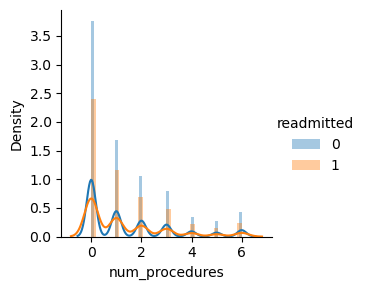

In [32]:
sns.FacetGrid(df,hue='readmitted').map(sns.distplot,'num_procedures').add_legend()

Distribution looks almost same for those with reamitted status and otherwise. Number of patient encounters with only 1 lab procedures is significantly more than those with 2,3 or other. Let's confirm the same with cumulative density plot

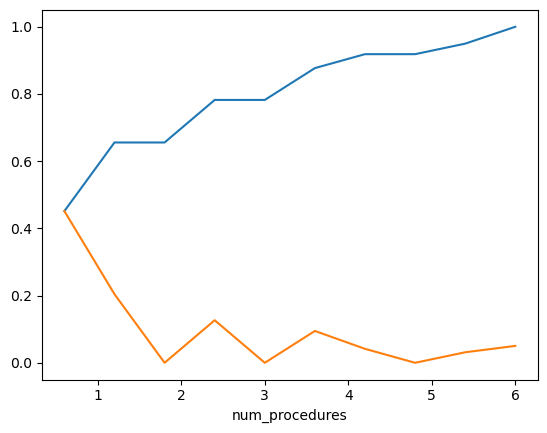

In [33]:
# reference : https://medium.com/@purnasaigudikandula/exploratory-data-analysis-beginner-univariate-bivariate-and-multivariate-habberman-dataset-2365264b751
counts, bin_edges = np.histogram(df['num_procedures'], bins=10, density=True)
pdf = counts/sum(counts)
cdf =np.cumsum(pdf)
plt.xlabel('num_procedures')
plt.plot(bin_edges[1:], cdf)
plt.plot(bin_edges[1:], pdf)

Number of patient encounters is highest for those with 1 lab procedure followed by others. 

In [34]:
_1_ = len(df[(df['readmitted']== 1) & (df['num_procedures'] != 0)])/ len(df[df['readmitted'] == 1]) 
_0_ = len(df[(df['readmitted']== 0) & (df['num_procedures'] != 0)])/ len(df[df['readmitted'] == 0]) 
print('Out of total patients that were readmitted {:.2f}% of patients had underwent multiple procedures'.format(_1_))
print('Out of total patients that were NOT readmitted {:.2f}% of patients had underwent multiple procedures'.format(_0_))

Out of total patients that were readmitted 0.55% of patients had underwent multiple procedures
Out of total patients that were NOT readmitted 0.55% of patients had underwent multiple procedures


<b>Query : </b><i> Is high number of procedures indicative of more susceptibility towards readmission ? </i>
    
There is no such relation as almost half of the patients that were readmitted underwent number of medical procedures. Same can be said about those that were not readmitted. 

#### 1.3.4 Univariate analysis of 'number_inpatient'

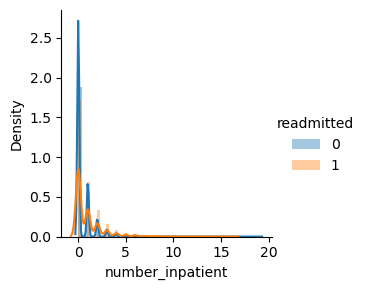

In [35]:
sns.FacetGrid(df,hue='readmitted').map(sns.distplot,'number_inpatient').add_legend()

Patients with number_inpatient count as 0 seem to have significantly low readmission rate. Let's confirm the same with countplot. 

AttributeError: 'numpy.int64' object has no attribute 'startswith'

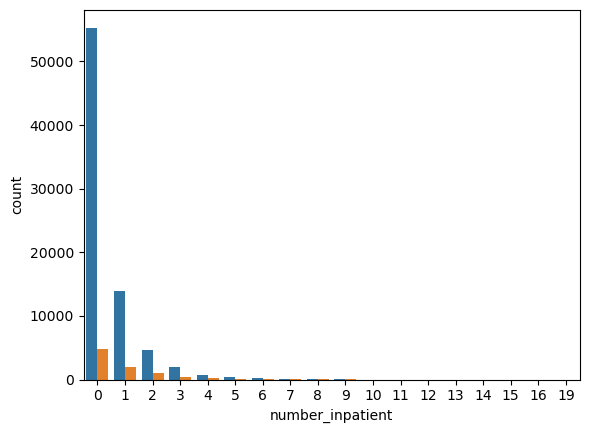

In [36]:
sns.countplot(x='number_inpatient', hue='readmitted', data=df)

Patients who were not readmitted again mostly have '0' inpatient count. 'number-inpatient' is therefore an important factor in determining the readmission status. 

In [37]:
per_0_ = len(df[(df['readmitted']== 1) & (df['number_inpatient'] == 0)])/ len(df[df['number_inpatient'] == 0]) 
per_1_ = len(df[(df['readmitted']== 1) & (df['number_inpatient'] != 0)])/ len(df[df['number_inpatient'] != 0]) 
print('{:.2f}% of patients with no inpatient history (i.e. never admitted before) were readmitted'.format(100*per_0_))
print('{:.2f}% of patients with inpatient history (i.e. were admitted before) were readmitted'.format(100*per_1_))

8.09% of patients with no inpatient history (i.e. never admitted before) were readmitted
15.27% of patients with inpatient history (i.e. were admitted before) were readmitted


<b> Query : </b><i> Are patients with inpatient encounter history( inpatient != 0 ) more susceptible for hospital readmission as high inpatient frequency denotes poor health ? </i>

Yes, from above graphs and percentage calculations, it is evident that 15% of the patients who were admitted before(inpatient>0) were readmitted which is greater than the percentage of patients with no inpatient history which is 8%. Thus, we can conclude that patients with inpatient history are more likely to get readmitted. 

#### 1.3.5 Univariate analysis of  'num_medications' feature

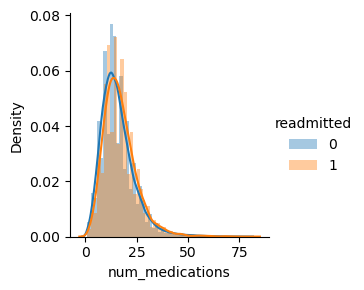

In [38]:
sns.FacetGrid(df,hue='readmitted').map(sns.distplot,'num_medications').add_legend()

Just like 'num_lab_procedures', distribution for 'num_medications' too is same for both readmitted patients and non-readmitted ones but as this has good variance, it will be helpful for model to find patterns in data.

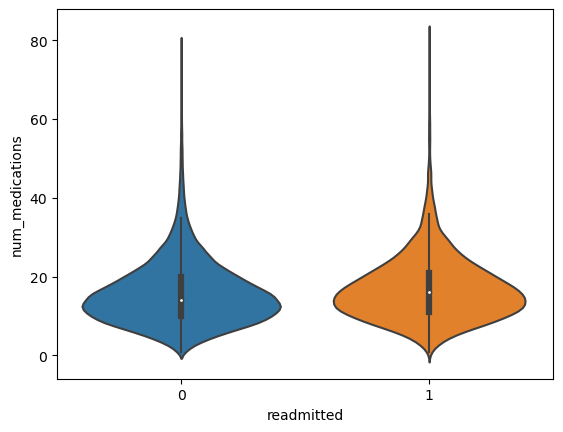

In [39]:
sns.violinplot(x='readmitted', y='num_medications', data=df, size=10)
plt.show()

<b>Query :</b> <i> Does high number of medications indicate greater chances of patient being readmitted as high number of medications implies poor health ? </i>

As we can see, distribution of num of medications is same for both re-admitted and non-readmitted patients. and number of medications mostly ranges in range of 1-30. This is same for both re-admitted as well as non-readmitted patients. Therefore, we can conclude that high number of medications does not necessarily imply poor health or more chances of getting readmitted.

#### 1.3.6 Univariate analysis of age 

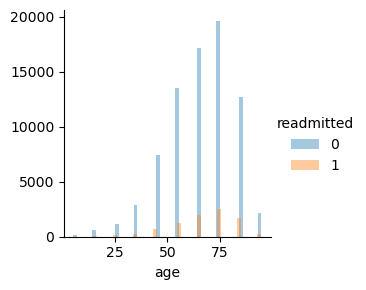

In [40]:
sns.FacetGrid(df,hue='readmitted').map(sns.distplot,'age', kde=False).add_legend()

<b> Query : </b> <i> Is any age group more susceptible to catch disease and get readmitted ? </i>

We can see patients with age in range 60-80 are more likely to fall ill and get admitted. However, we cannot make any conclusion about readmission status as the distribution of patients who were readmitted and otherwise is same.

#### 1.3.7 Univariate analysis of  gender

AttributeError: 'numpy.int64' object has no attribute 'startswith'

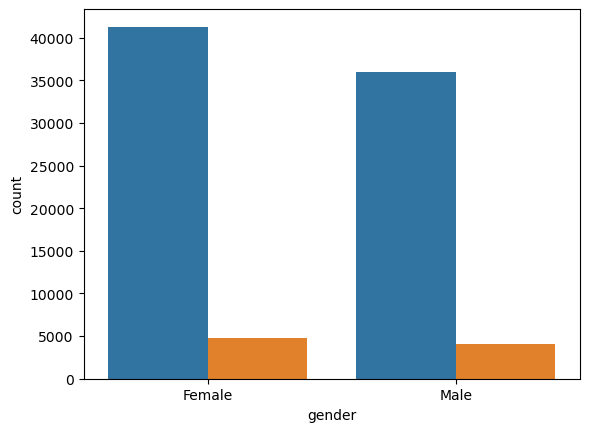

In [41]:
sns.countplot( x ='gender', hue='readmitted', data=df)

In [42]:
per_0_ = len(df[(df['readmitted']== 1) & (df['gender'] == 'Female')]) / len(df[df['gender'] == 'Female']) 
per_1_ = len(df[(df['readmitted']== 1) & (df['gender'] == 'Male')] )  / len(df[df['gender'] == 'Male']) 
print('Percentage of females, who were readmitted is {:.2f}'.format( per_0_))
print('Percentage of males, who were readmitted is {:.2f}'.format(per_1_))

Percentage of females, who were readmitted is 0.10
Percentage of males, who were readmitted is 0.10


<b>Query :</b><i> Is any gender more susceptible to be readmitted ? </i>

No, as we can see, here, distribution of patients of both genders is almost same. Further, 10% of males were readmitted, this is same as that of females i.e. 10% of females were readmitted. 

### 1.4  Bivariate Analysis 

#### 1.4.1 Bivariate analysis of age and and time_in_hospital

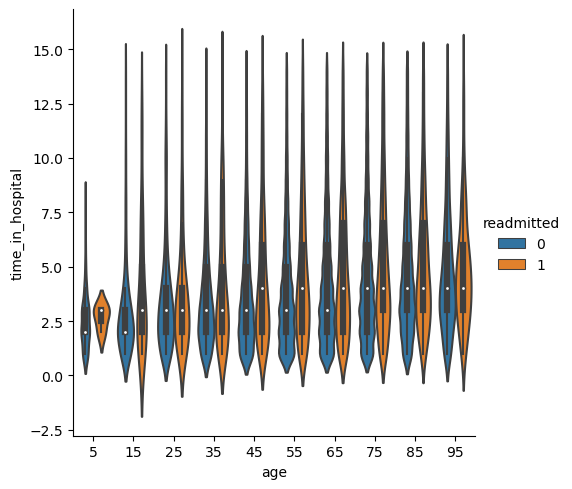

In [43]:
sns.catplot(x="age", y="time_in_hospital", hue="readmitted", kind="violin", data=df, size=10)

<b>Query : </b> <i> Is there any meaningful pattern between age and medical stay ?</i>

For people in the age group 50-70 (represented by '55' and '65') we can clearly see a pattern where patients that stay longer are more likely to be readmitted. This is evident from the median stay value represented by white dot insidde the boxplot in violin plot. <br>
Similarly, people above 55 years of age that stay longer are more likely to be readmitted.

<b>Query : </b> <i> Does old age patients require more attention and longer treatment ?</i>

As evident from graph above, patients below age 35 are admitted for hardly 4-5 days, older patients with age more than or equal to 35 tend to need longer medical stay of 6-7 days and even upto 12-13 days for rare cases. 

#### 1.4.2 Bivariate analysis of gender and number of diagnosis

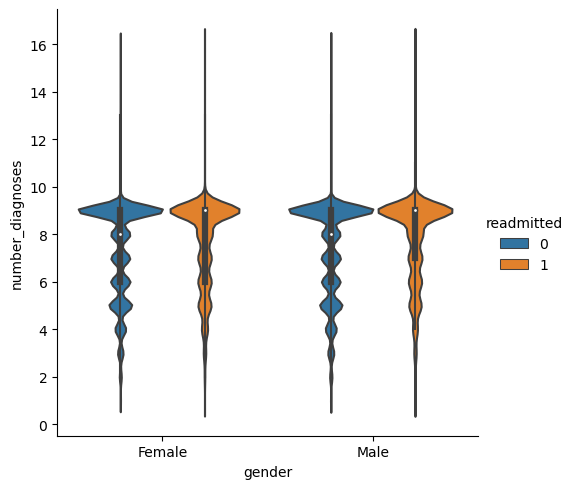

In [44]:
sns.catplot(x="gender", y="number_diagnoses", hue="readmitted", kind="violin", data=df, size=6)

<b>Query :</b><i> Is there any relation between between gender and the number of diseases patient is suffering from ? If yes, which gender is more healthy ?</i>

No. As seen here, both males and females are diagnosed with almost same number of diseases/disorders and there isn't any particular pattern that would lead us to conclusion that one gender is healthier than other. However, we can see, males who were readmitted largely underwent 7-9 diagnosis, females on other hand had 6-9 diagnosis.

Median number of diagnosis for both males and females for readmitted patients in higher than that of non-readmitted ones. Thus patients that have more number of diagnosis are more likely to be readmitted regardless of gender.

#### 1.4.3 Bivariate analysis of race and number of diagnosis

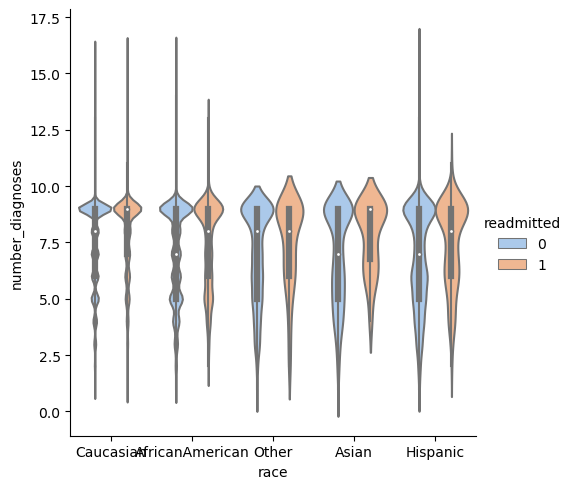

In [45]:
sns.catplot(x="race", y="number_diagnoses", hue="readmitted", kind="violin", palette='pastel', data=df, size=10)

<b>Query :</b><i> Is there any relation between between race and the number of diseases patient is suffering from ? If yes, which race is more healthy ?</i>

No. As seen here, people of different races are diagnosed with almost same number of diseases/disorders and there isn't any particular pattern that would lead us to conclusion that one race is healthier than other.

#### 1.4.4 Bivariate analysis of age and gender

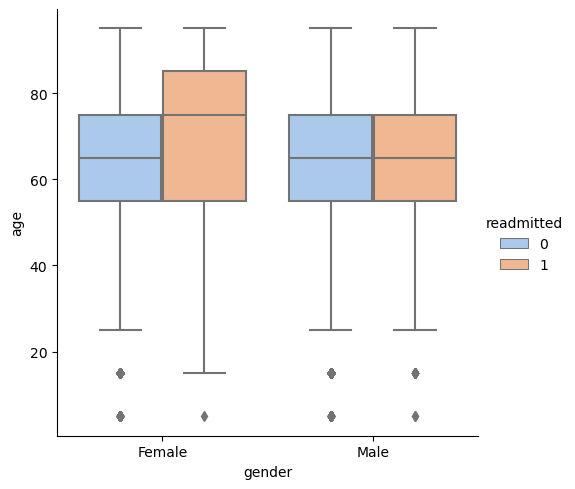

In [46]:
sns.catplot(x="gender", y="age", hue="readmitted", kind="box", palette='pastel', data=df)

<b>Query :</b><i> From univariate analysis of age, we know that older people are more susceptible to be readmitted. Is it the same for both genders ? </i>

As seen from above box-plot, older females of age greater than 70 are more likely to be readmitted which isn't the case with males. Thus, we can conclude that older females need more care so as to prevent their readmission.

### 1.5 Feature Engineering 

#### Examining dataset to find missing values

In [47]:
columns_with_nan = df.columns[df.isna().any()].tolist()
print(columns_with_nan)

['race', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult']


Columns 'race', 'gender', 'payer_code', 'medical_specialty', 'diag_3', 'diag_2', 'diag_1' have missing values and therefore need to be imputed. 

In [48]:
print('Percentage of missing values for "race" column is {:.2f}%'.format(df['race'].isnull().sum()/len(df['race'])))
print('Percentage of missing values for "weight" column is {:.2f}%'.format(df['weight'].isnull().sum()/len(df['weight'])))
print('Percentage of missing values for "payer_code" column is {:.2f}%'.format(df['payer_code'].isnull().sum()/len(df['payer_code'])))
print('Percentage of missing values for "medical_specialty" column is {:.2f}%'.format(df['medical_specialty'].isnull().sum()/len(df['medical_specialty'])))
print('Percentage of missing values for "diag_1" column is {:.5f}%'.format(df['diag_1'].isnull().sum()/len(df['diag_1'])))
print('Percentage of missing values for "diag_2" column is {:.5f}%'.format(df['diag_2'].isnull().sum()/len(df['diag_2'])))
print('Percentage of missing values for "diag_3" column is {:.5f}%'.format(df['diag_3'].isnull().sum()/len(df['diag_3'])))

Percentage of missing values for "race" column is 0.02%
Percentage of missing values for "weight" column is 0.97%
Percentage of missing values for "payer_code" column is 0.41%
Percentage of missing values for "medical_specialty" column is 0.48%
Percentage of missing values for "diag_1" column is 0.00024%
Percentage of missing values for "diag_2" column is 0.00383%
Percentage of missing values for "diag_3" column is 0.01500%


#### 1.5.1 Missing value imputation for diag_1, diag_2 and diag_3

For columns 'diag_1', 'diag_2' and 'diag_3', the percentage of missing values is less than 1% and therefore these values can be easily imputed using mode imputation as these are categorical features.

In [49]:
# Performing mode imputation for columns 'diag_1', 'diag_2', 'diag_3' columns
df['diag_1'].fillna(df['diag_1'].mode()[0], inplace=True)
df['diag_2'].fillna(df['diag_2'].mode()[0], inplace=True)
df['diag_3'].fillna(df['diag_3'].mode()[0], inplace=True)

#### Feature engineering for diag_1, diag_2 and diag_3

Let's check the number of categorical values for these features.

In [50]:
print(len(df['diag_1'].unique()))
print(len(df['diag_2'].unique()))
print(len(df['diag_3'].unique()))

705
732
776


As the number of possible values for those features is too high, their possible cominations is of order 6-7. When we will do one hot encoding for the data, this high number of dimensions will degrade the model performance owing to curse of dimensionality.

In [51]:
df['diag_1'].value_counts()[::-1][:20]

diag_1
V51       1
691       1
250.51    1
955       1
216       1
477       1
318       1
471       1
982       1
347       1
870       1
834       1
148       1
817       1
27        1
684       1
314       1
57        1
915       1
842       1
Name: count, dtype: int64

Features 'diag_1', 'diag_2' and 'diag_3' have a large number of values with value_count 1 or a single or double digit count. ML algorithm can't capture the pattern of those values as categorical value with single digit or double digit count is too small to find any meaningful pattern in it. Let's convert all categorical values of diag_1,diag_2 and diag_3 with count less than 100 into separate categorical value as other. 

In [52]:
# create mask 
mask_diag_1 = df.diag_1.map(df.diag_1.value_counts()) < 100
mask_diag_2 = df.diag_2.map(df.diag_2.value_counts()) < 100
mask_diag_3 = df.diag_3.map(df.diag_3.value_counts()) < 100
# replacing values with filtered mask
df.diag_1 = df.diag_1.mask(mask_diag_1, 'other')
df.diag_2 = df.diag_2.mask(mask_diag_2, 'other')
df.diag_3 = df.diag_3.mask(mask_diag_3, 'other')

After replacing all small categorical values less than 100, total number of different categorical values for diag_1,diag_2 and diag_3 are as follows :

In [53]:
print(len(df['diag_1'].unique()))
print(len(df['diag_2'].unique()))
print(len(df['diag_3'].unique()))

126
117
128


#### 1.5.2 Analysing feature 'race'

For column 'race' 2% of data is missing. 

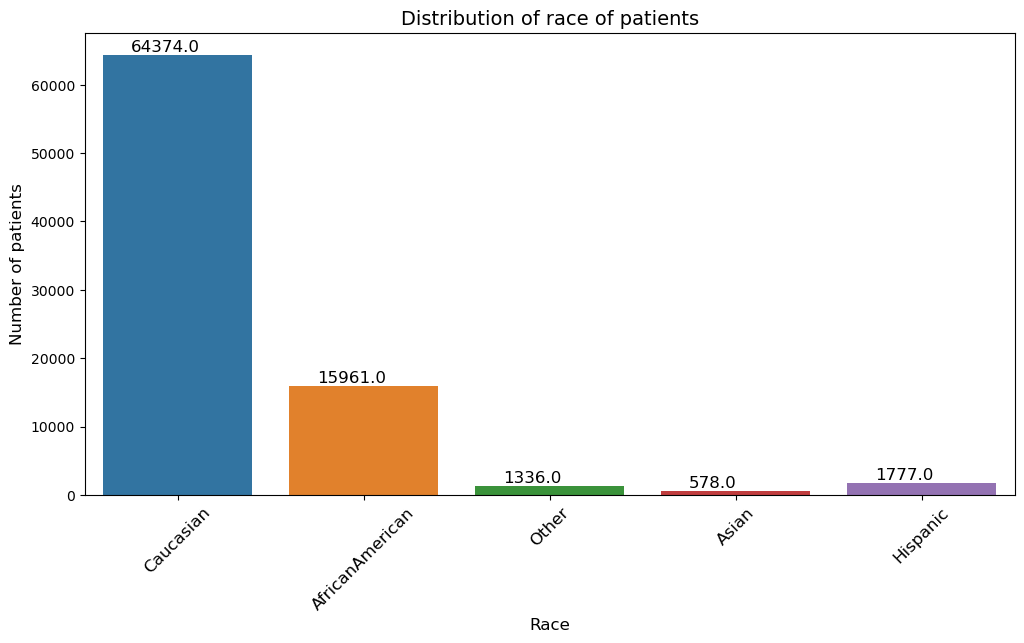

In [54]:
# plotting the count of different values in target variable 'readmitted'
plt.figure(figsize=(12,6))
ax = sns.countplot(x=df['race'])
plt.title('Distribution of race of patients', fontsize=14)
plt.xlabel('Race', fontsize=12)
plt.ylabel('Number of patients', fontsize=12)
plt.xticks(rotation=45, fontsize=12)

total = len(df['race'])
for p in ax.patches:
    count = '{}'.format(p.get_height())
    x = p.get_x() + .15 
    y = p.get_y() + p.get_height() + 500
    ax.annotate(count, (x, y), fontsize=12)

plt.show()

Feature race has 5 unique values with 'Caucasian' being the largest of them.

#### Missing value imputation for feature 'race'

As seen from above as 'Caucasian' race is the largest 'race' for our dataset. Also, largest race in America (reference :https://en.wikipedia.org/wiki/White_Americans) is the same. It therefore, won't be wrong to assume that majority of those missing race values are 'Cacucasian'. Therefore, let's perform a 'mode' imputation for missing values by filling them with 'Caucassian' as their value. 

In [55]:
# performing Mode imputation for missing values in 'race' column
df['race'].fillna(df['race'].mode()[0], inplace=True)

#### 1.5.3 Missing value imputation for 'payer_code'

41% data is missing so, let's place 'UK' (unknown) for those missing values

In [56]:
# performing missing value imputation for missing values in medical_specialty column
df['payer_code'].fillna('UK', inplace=True) 

#### Analysing feature 'payer code'

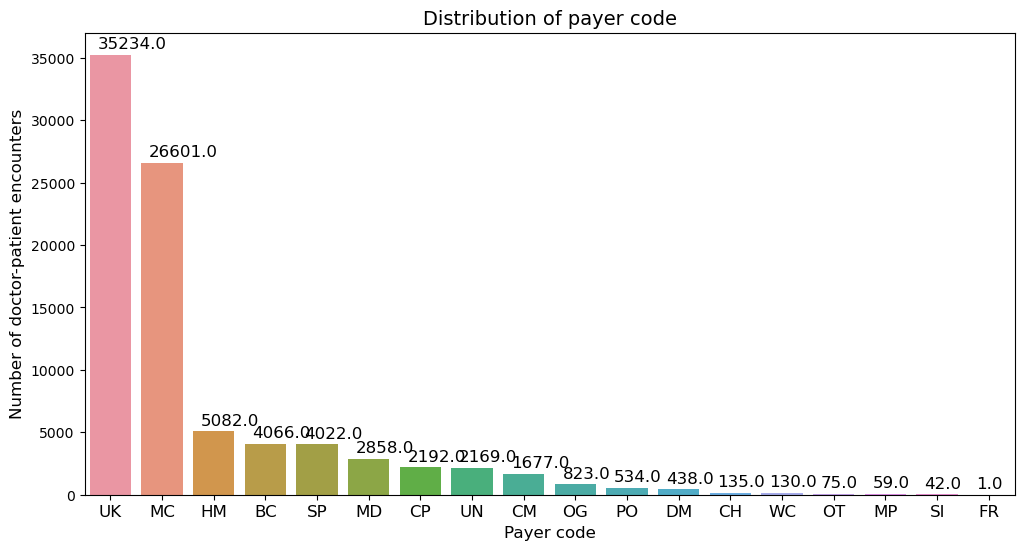

In [57]:
# plotting the count of different values in target variable 'readmitted'
plt.figure(figsize=(12,6))
ax = sns.countplot(x=df['payer_code'], order =df['payer_code'].value_counts().index) 
plt.title('Distribution of payer code', fontsize=14)
plt.xlabel('Payer code', fontsize=12)
plt.ylabel('Number of doctor-patient encounters', fontsize=12)
plt.xticks(fontsize=12)

total = len(df['payer_code'])
for p in ax.patches:
    count = '{}'.format(p.get_height())
    x = p.get_x() + .15 
    y = p.get_y() + p.get_height() + 500
    ax.annotate(count, (x, y), fontsize=12)

plt.show()

#### Feature engineering for 'payer code'

Feature values 'OT', 'MP', 'SI' and 'FR' have counts less than 100, ML model won't be able to find meaning ful patterns with these values as there count is too low. Let's replace them with 'MN' short for 'minor' as value.

In [58]:
mask_payer_code = df.payer_code.map(df.payer_code.value_counts()) < 100
# replacing values with filtered mask
df.payer_code = df.payer_code.mask(mask_payer_code, 'MN')
df['payer_code'].value_counts()

payer_code
UK    35234
MC    26601
HM     5082
BC     4066
SP     4022
MD     2858
CP     2192
UN     2169
CM     1677
OG      823
PO      534
DM      438
MN      177
CH      135
WC      130
Name: count, dtype: int64

#### 1.5.4 Missing value imputation for feature 'weight'

For column 'weight' 97% of data is missing, so we cannot perform mode imputation or model imputation or implement any other conventional missing value imputation method. Missing data might have some reason behind it. Let's try to capture the same by converting it into binary feature such that missing value wil be given value '0' and those where value is present let's give it value '1'.

In [59]:
# performing mode imputation for missing values in medical_specialty column
df['weight'].fillna(0, inplace=True)
df.loc[df['weight'] != 0, 'weight' ]=1

#### 1.5.5 Missing value imputation for feature 'medical_specialty'

49% data is missing for 'medical_specialty'. Let's impute it with value 'unknown' for missing values.

In [60]:
# performing missing value imputation for missing values in medical_specialty column
df["medical_specialty"].fillna('unknown', inplace=True)

#### Analysing feature 'medical_speicalty'

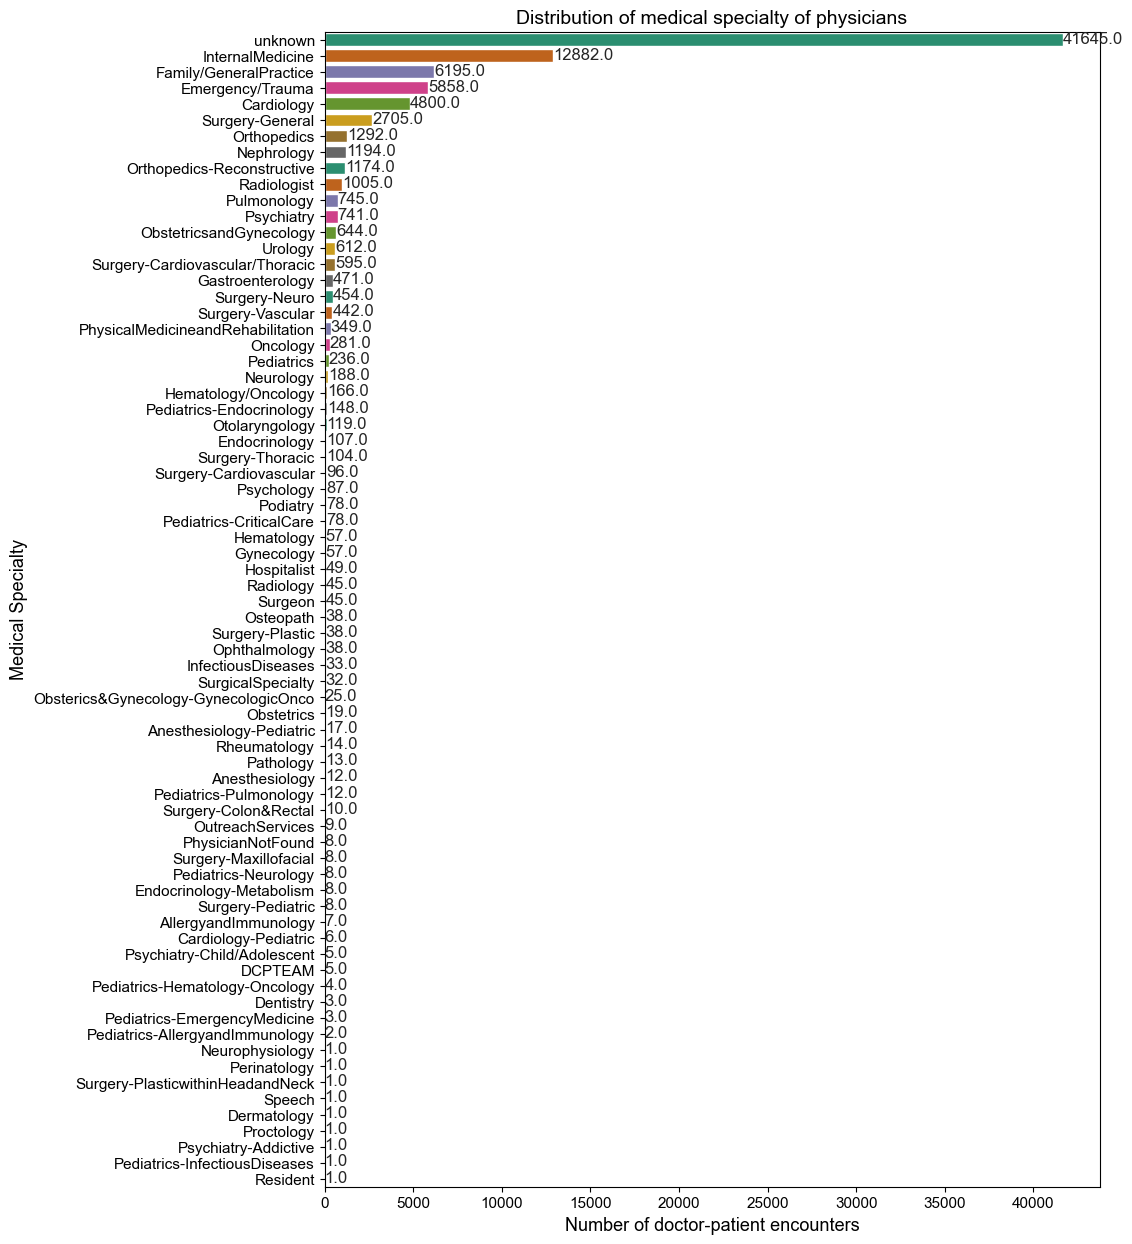

In [61]:
fig, ax= plt.subplots(figsize =(10,15))
sns.set_style('whitegrid')
sns.set_context('notebook')
ax=sns.countplot( palette="Dark2",ax=ax,y='medical_specialty',order =df['medical_specialty'].value_counts().index, data=df)

for p in ax.patches:
    percentage ='{}'.format(p.get_width())
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.5
    y=p.get_y()+height/2+0.2
    ax.annotate(percentage,(x,y), fontsize=12)

plt.xticks(fontsize =11)
plt.yticks(fontsize =11)

plt.title('Distribution of medical specialty of physicians',fontsize =14 )
plt.xlabel ('Number of doctor-patient encounters',fontsize =13)
plt.ylabel ('Medical Specialty',fontsize =13)
plt.show ()

#### Feature engineering for 'medical specialty'

Lot of categorical values of medical specialty have count less than 100. Let's change their categorical value to 'minority'

In [62]:
mask_medical_specialty = df.medical_specialty.map(df.medical_specialty.value_counts()) < 100
# replacing values with filtered mask
df.medical_specialty = df.medical_specialty.mask(mask_medical_specialty, 'minority')

#### Feature engineering for number_emergency

In [63]:
df.number_emergency.value_counts()

number_emergency
0     77749
1      5946
2      1479
3       478
4       198
5       111
6        60
7        30
8        20
9        13
10       12
11        9
13        6
12        5
16        4
22        3
25        2
15        2
14        2
42        1
28        1
37        1
19        1
64        1
20        1
18        1
54        1
29        1
Name: count, dtype: int64

Values with count more than 10 are rare. So, let's group them under one category. All values with count greater than 10, will have value 11. 

In [64]:
mask_number_emergency = df.number_emergency.map(df.number_emergency.value_counts()) < 10
# replacing values with filtered mask
df.number_emergency = df.number_emergency.mask(mask_number_emergency, 11)

In [65]:
df.number_emergency.value_counts().sort_index()

number_emergency
0     77749
1      5946
2      1479
3       478
4       198
5       111
6        60
7        30
8        20
9        13
10       12
11       42
Name: count, dtype: int64

#### Feature Engineering for feature number inpatients 

In [66]:
df['number_inpatient'].value_counts()

number_inpatient
0     60194
1     15810
2      5632
3      2376
4      1037
5       477
6       293
7       132
8        67
9        56
10       21
12       15
11       14
13        5
16        4
15        3
19        1
14        1
Name: count, dtype: int64

In [67]:
mask_number_inpatient = df.number_inpatient.map(df.number_inpatient.value_counts()) < 50
# replacing values with filtered mask
df.number_inpatient = df.number_inpatient.mask(mask_number_inpatient, 10)

In [68]:
df.number_inpatient.value_counts()

number_inpatient
0     60194
1     15810
2      5632
3      2376
4      1037
5       477
6       293
7       132
8        67
10       64
9        56
Name: count, dtype: int64

#### Feature engineering for number of diagnoses  

In [69]:
df['number_diagnoses'].value_counts()

number_diagnoses
9     40730
5     10231
8      8893
7      8847
6      8767
4      4904
3      2549
2       918
1       202
16       37
10       17
13       14
15       10
11        8
12        6
14        5
Name: count, dtype: int64

In [70]:
mask_number_diagnoses = df.number_diagnoses.map(df.number_diagnoses.value_counts()) <= 100
# replacing values with filtered mask
df.number_diagnoses = df.number_diagnoses.mask(mask_number_diagnoses, 10)

In [71]:
df.number_diagnoses.value_counts()

number_diagnoses
9     40730
5     10231
8      8893
7      8847
6      8767
4      4904
3      2549
2       918
1       202
10       97
Name: count, dtype: int64

#### Feature engineering for discharge disposition id

In [72]:
df.discharge_disposition_id.value_counts()

discharge_disposition_id
1     52123
3     12022
6     10773
26     3957
2      1793
22     1726
5      1066
4       712
7       513
13      388
14      370
23      355
28      114
8        94
15       46
24       38
9        15
17       12
16        9
10        6
27        4
12        2
Name: count, dtype: int64

Categories labelled as '16', '10', '27' and '12' have very small count which is not enough for the model to make any meaningful inference from. Let's group them together under a category which we will categorize as 'other' and let it be represented by value '10' 

In [73]:
mask_discharge_disposition_id = df.discharge_disposition_id.map(df.discharge_disposition_id.value_counts()) <= 10
# replacing values with filtered mask
df.discharge_disposition_id = df.discharge_disposition_id.mask(mask_discharge_disposition_id, 10) 

In [74]:
df.discharge_disposition_id.value_counts().sort_index()

discharge_disposition_id
1     52123
2      1793
3     12022
4       712
5      1066
6     10773
7       513
8        94
9        15
10       21
13      388
14      370
15       46
17       12
22     1726
23      355
24       38
26     3957
28      114
Name: count, dtype: int64

#### Feature engineering for admission source id

In [75]:
df['admission_source_id'].value_counts()

admission_source_id
7     47198
1     25754
15     6114
4      2978
6      2151
2       994
5       751
3       159
8        14
22       10
10        8
14        2
11        2
25        2
13        1
Name: count, dtype: int64

Let's group patient with values 10,25,14,11 and 13 into category 'other' and represent as '10'

In [76]:
mask_admission_source_id = df.admission_source_id.map(df.admission_source_id.value_counts()) <= 10
# replacing values with filtered mask
df.admission_source_id = df.admission_source_id.mask(mask_admission_source_id, 10) 

In [77]:
df.admission_source_id.value_counts().sort_index()

admission_source_id
1     25754
2       994
3       159
4      2978
5       751
6      2151
7     47198
8        14
10       25
15     6114
Name: count, dtype: int64

#### Checking for data imbalance

<Axes: ylabel='count'>

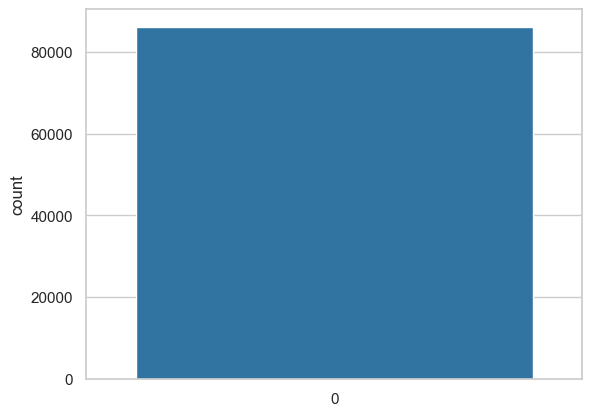

In [78]:
sns.countplot(df['readmitted'])

only 1/10th of patients were readmitted in 30 days, thus, our data is highly imbalanced. We will deal with the imbalance in dataset after train test split, as we need to perform oversampling only on train data and not on test data.

### 1.6 Feature Selection

In [79]:
X = df.drop(columns=['readmitted'])
y = df['readmitted'].values
print(np.unique(y,return_counts=True))


(array([0, 1]), array([77304,  8834]))


In [80]:
# splitting the data into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
print(np.unique(y_train,return_counts=True))

(array([0, 1]), array([49474,  5654]))


#### 1.6.1 One hot encoding data

Our dataset consists of int datatypes and string datatype values. However, integer values (as in age, disposition_id, etc) are actually representation of categorical values. Therefore, one way to vectorize these features is to perform one hot encoding for complete dataset ie. both integer value features and string valued features. 

In [81]:
def onehotfeaturization(X_train, X_valid):
    """ This function does one-hot encoding of data
        input : training, validation or test dataset
        outut : one-hot encoded representation of dataset
    """
    # converting all features to 'str' datatype for one hot encoding
    X_train,X_valid = X_train.astype(str), X_valid.astype(str)
    # OneHotEncoding data
    onehot = OneHotEncoder(handle_unknown='ignore', categories='auto')
    try : 
        onehot.fit(X_train)
    except : 
        X_train = np.array(X_train).reshape(-1,1)
        onehot.fit(X_train)
        X_valid = np.array(X_valid).reshape(-1,1)
        
    X_tr = onehot.transform(X_train)
    X_va = onehot.transform(X_valid)
    return X_tr, X_va  # compressed row format

#### 1.6.2 Forward Feature Selection 

After encoding, we will get around 851 different features, which is too high. Let's perform forward feature selection to reduce the number of features and select the best few. 

In [82]:
def first_best_feature(X_train,X_valid,y_train,y_valid):
    """This function finds the feature that contributes the most in determining the output variable. It is part of forward 
       feature selection method
       input  : Training and validation dataset along with corresponding target variables
       output : best feature in the dataset,auc-score,recall and confusion matrix obtained by one feature alone, 
                confusion matrix 
    """
    max_auc,max_recall = 0,0
    for i in X_train.columns : 
        X_tr,X_va =  onehotfeaturization(X_train[i],X_valid[i])
        lg = SGDClassifier(class_weight='balanced', alpha=.001, random_state=0, loss='log', penalty="l2")
        lg.fit(X_tr,y_train)

        y_pred = lg.predict(X_va)
        y_proba = lg.predict_proba(X_va)
        auc = roc_auc_score(y_valid, y_proba[:,1])
        recall = recall_score(y_valid, y_pred)
        cf = confusion_matrix(y_valid,y_pred)
        if auc > max_auc :
            max_auc = auc
            max_recall = recall
            best_feature = i
    return max_auc,max_recall, best_feature,cf

In [83]:
def forward_feature_selection(X_train,X_valid,y_train,y_valid):
    """This function implements forward feature selection strategy to find the best features in dataset.
       input  : Training and validation dataset along with corresponding target variables
       output : set of best features along with auc, recall and confusion matrix obtained by those features on
                validation dataset
    """
    max_auc, max_recall, best_feature,cf = first_best_feature(X_train,X_valid,y_train,y_valid)
    auc_list,recall_list,features_list,cf_list = [max_auc],[max_recall],[best_feature],[cf]
    
    unused_cols = list(X_train.columns)
    unused_cols.remove(best_feature)
    used_cols = [best_feature]
    cnt = 0
    while cnt < 40 : 
        flag = 0
        for i in unused_cols : 
            temp_col_list = used_cols.copy()
            temp_col_list.append(i)
            X_tr,X_va = onehotfeaturization(X_train[temp_col_list],X_valid[temp_col_list])
            lg = SGDClassifier(class_weight='balanced', alpha=.001, random_state=0, loss='log', penalty="l2")
            lg.fit(X_tr,y_train)

            y_pred = lg.predict(X_va)
            y_proba = lg.predict_proba(X_va)
            auc = roc_auc_score(y_valid, y_proba[:,1])
            recall = recall_score(y_valid, y_pred)
            cf = confusion_matrix(y_valid,y_pred)
            if auc > max_auc :
                max_auc = auc
                max_recall = recall
                best_cf = cf
                best_feature = i
                flag = 1
                
        if flag == 1 : 
            auc_list.append(max_auc)
            recall_list.append(max_recall)
            features_list.append(best_feature)
            cf_list.append(best_cf)
            used_cols.append(best_feature)
            unused_cols.remove(best_feature)
        cnt+=1
        
    return auc_list,recall_list,features_list,cf_list

In [84]:
auc_list,recall_list,features_list, cf_list = forward_feature_selection(X_train,X_valid,y_train,y_valid)

Here is the list of best features that gives the maximum auc possible for this dataset.

In [85]:
print('Best features are : {}'.format(features_list))
print('The maximum auc obtained is {:.2f}'.format(auc_list[-1]))

Best features are : ['discharge_disposition_id', 'number_inpatient', 'number_diagnoses', 'diabetesMed', 'diag_2', 'admission_source_id', 'A1Cresult', 'number_emergency']
The maximum auc obtained is 0.67


## 2. Model Selection

Now, that we have the important features selected, let's train all the classical machine learning models that satisfy our business requirements to choose the best model. 

In [86]:
features_list =['discharge_disposition_id', 'number_inpatient', 'number_diagnoses', 'diabetesMed', 'diag_2',
                'admission_source_id','A1Cresult', 'number_emergency']

In [87]:
# creating dataset with best features
X_tr = X_train[features_list]
X_va = X_valid[features_list]
# Doing one-hot encoding on selected features
X_tr,X_va = onehotfeaturization(X_tr, X_va)

#### 2.1 Implementing SMOTE for oversampling to compensate for data imbalance

As we can see, data is highly imbalanced, for models like logistic regression, decision trees and random forest classifier we can use the parameter 'class_weight'(provided by sklearn) and set it to 'balanced' to deal with data imbalance. However, for Naive Bayes and KNN, we don't have this parameter. So we will perform oversampling using SMOTE technique to compensate the imbalance in dataset. 

In [88]:
def oversampling(X_train, y_train):
    """This function implement oversampling strategy to increase the number of minority class in imbalanced dataset so as 
       to balance the dataset
       
       Input  : Imbalanced Training dataset - x_train and y_train
       Output : Balanced Training dataset - x_train and y_train
    """
    # define pipeline and implement SMOTE oversampling method for minority class
    over = SMOTE(sampling_strategy=.9)
    steps = [('o', over)]
    pipeline = Pipeline(steps=steps)
    # transform the dataset
    X_train, y_train = pipeline.fit_resample(X_train, y_train)
    return X_train, y_train

In [89]:
def score_calculations(X_valid,y_valid, model):
    """This function takes in validation data, corresponding labels and the trained ML model. It calculates auc score, 
       recall score and confusion matrix. 
       
       Input  : Validation data along with corresponding labels and trained model
       Output : AUC score, Recall score and confusion matrix score given by model on validation data
    """
    y_pred = model.predict(X_valid)
    y_proba = model.predict_proba(X_valid)
    auc = roc_auc_score(y_valid, y_proba[:,1])
    binary_recall = recall_score(y_valid, y_pred, average='binary')
    macro_recall = recall_score(y_valid, y_pred, average='macro')
    macro_f1 = f1_score(y_valid, y_pred, average='macro')
    cf = confusion_matrix(y_valid,y_pred)
    return auc,binary_recall,macro_recall, macro_f1, cf

In [90]:
plt.rcParams.update({'font.size': 14})
def plot_confusion_matrix(model,auc,recall,mac_recall, mac_f1,cf):
    """This function takes in model name, auc score, recall score and confusion matrix. It plots confusion matrix along with
       corresponding auc score and recall score.
       
       Input : model name, auc score, recall score(both binary and macro), macro f1 score, confusion matrix
       Output : returns nothing; prints confusion matrix,acu,recall and f1 scores
    """
    cf_matrix = cf
    group_names = ['True Negative','False Positive','False Negative', 'True Positive']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)
    plt.title('\nModel : {}\n AUC score : {:.2f}\n Recall score : {:.2f}\n Macro Recall : {:.2f}\n Macro F1 score : {:.2f}'.format(model,auc,recall,mac_recall,mac_f1), fontsize=16)
    plt.show()
    print('*************************************************\n\n\n')

#### 2.2 Training and Hyperparameter tuning for different ML models 

In [91]:
def find_best_model(X_train,X_valid,y_train,y_valid):
    """This model takes in training data, validation data along with corresponding labels. It trains ML modles namely 
       logistic Regression, Decision Tree Classifier, Random Forest Classifier, Naive Bayes and KNN. Does hyper-parameter
       tuning, plots the confusion matrix obtained on validation data and returns the scores obtained by each model. 
       
       Input  : Training and validation data along with corresponding labels - X_train,X-valid, y_train, y_valid
       Output : Trained models along with corresponding validation auc, recall and confusion matrix scores
    """
    
    # Model 1 : Logistic Regression 
    model_1 = SGDClassifier( class_weight= 'balanced', random_state=0, loss='log')
    param_dict_1 = { 'alpha':[.0001, .001,.01,1,10], 'penalty':["l2", "elasticnet"] }
    cv_model_1 = GridSearchCV(model_1,param_grid=param_dict_1, cv=10, n_jobs=-1,verbose=1,refit='roc_auc',scoring=['roc_auc', 'recall'])
    cv_model_1.fit(X_train,y_train)
    auc_1, recall_1,mac_recall_1,mac_f1, cf_1 = score_calculations(X_valid,y_valid, cv_model_1)
    plot_confusion_matrix("Logistic Regression",auc_1,recall_1,mac_recall_1,mac_f1, cf_1)
    
    # Model 2 : Decision Tree classifier
    model_2 = DecisionTreeClassifier(class_weight="balanced",criterion="gini",  random_state=0)
    param_dict_2 = { "max_depth": [5,10,20,30,50] }
    cv_model_2 = GridSearchCV(model_2,param_grid=param_dict_2, cv=10, n_jobs=-1,verbose=1,refit='roc_auc', scoring=['roc_auc', 'recall'] )
    cv_model_2.fit(X_train,y_train)
    auc_2, recall_2,mac_recall_2,mac_f2,cf_2 = score_calculations(X_valid,y_valid, cv_model_2)
    plot_confusion_matrix("Decision Tree",auc_2,recall_2,mac_recall_2,mac_f2,cf_2)    
    
    # Model 3 : Random Forest Classifier 
    model_3 = RandomForestClassifier(random_state=0, class_weight="balanced",criterion="gini")
    param_dict_3 = { 'max_depth':[ 3,5,7 ] ,'n_estimators': [200,300,400] }
    cv_model_3 = GridSearchCV(model_3,param_grid=param_dict_3, cv=3, n_jobs=-1,verbose=1,refit='roc_auc', scoring=['roc_auc', 'recall'] )
    cv_model_3.fit(X_train,y_train)
    auc_3, recall_3,mac_recall_3,mac_f3, cf_3 = score_calculations(X_valid,y_valid, cv_model_3)
    plot_confusion_matrix("Random Forest",auc_3,recall_3,mac_recall_3,mac_f3, cf_3)    
    
    # oversampling the minority class datapoints
    X_train, y_train =  oversampling(X_tr, y_train)
    
    # Model 4 : Naive Bayes
    model_4 = BernoulliNB()
    param_dict_4 = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0] }
    cv_model_4=  GridSearchCV(model_4,param_grid=param_dict_4, cv=10, n_jobs=-1,verbose=1,refit='recall', scoring=['roc_auc', 'recall'] )
    cv_model_4.fit(X_train,y_train)
    auc_4, recall_4, mac_recall_4,mac_f4, cf_4 = score_calculations(X_valid,y_valid, cv_model_4)
    plot_confusion_matrix("Naive Bayes",auc_4,recall_4,mac_recall_4,mac_f4, cf_4) 

    # Model 5 : KNN
    model_5 = KNeighborsClassifier(weights="distance", metric= "minkowski", p = 2)
    param_dict_5 = { 'n_neighbors' : [2,3,5,10,15 ] }
    cv_model_5= GridSearchCV(model_5,param_grid=param_dict_5, cv=5, n_jobs=-1,verbose=1,refit='roc_auc', scoring=['roc_auc', 'recall'] )
    cv_model_5.fit(X_train,y_train)
    auc_5, recall_5,mac_recall_5,mac_f5, cf_5 = score_calculations(X_valid,y_valid, cv_model_5)
    plot_confusion_matrix("KNN",auc_5,recall_5,mac_recall_5,mac_f5,cf_5)
    
    auc_list = [auc_1, auc_2, auc_3, auc_4, auc_5]
    recall_list = [ recall_1, recall_2, recall_3, recall_4, recall_5 ]
    mac_recall_list = [ mac_recall_1, mac_recall_2, mac_recall_3, mac_recall_4, mac_recall_5  ]
    mac_f1_list = [mac_f1,mac_f2, mac_f3, mac_f4, mac_f5 ]
    cf_list = [cf_1, cf_2, cf_3, cf_4, cf_5 ]
    model_names = ["Logistic Reg","Decision Trees","Random Forest","Naive Bayes","KNN"]
    model_list = [ cv_model_1, cv_model_2, cv_model_3, cv_model_4, cv_model_5 ]
    
    return auc_list,recall_list,mac_recall_list, mac_f1_list, cf_list,model_names, model_list

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/opt/anaconda3/lib/python3.1

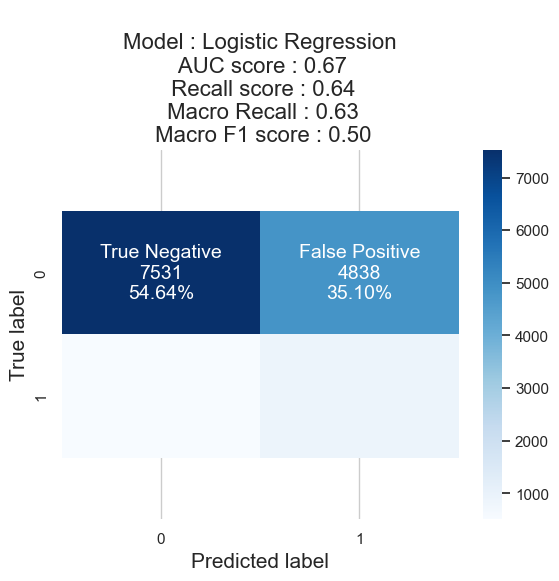

*************************************************



Fitting 10 folds for each of 5 candidates, totalling 50 fits


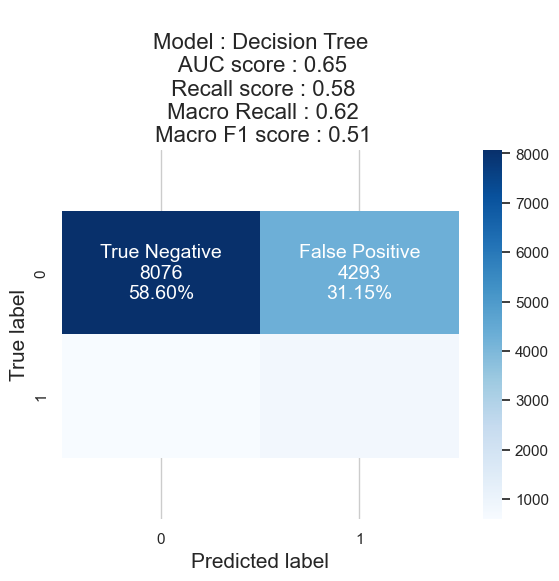

*************************************************



Fitting 3 folds for each of 9 candidates, totalling 27 fits


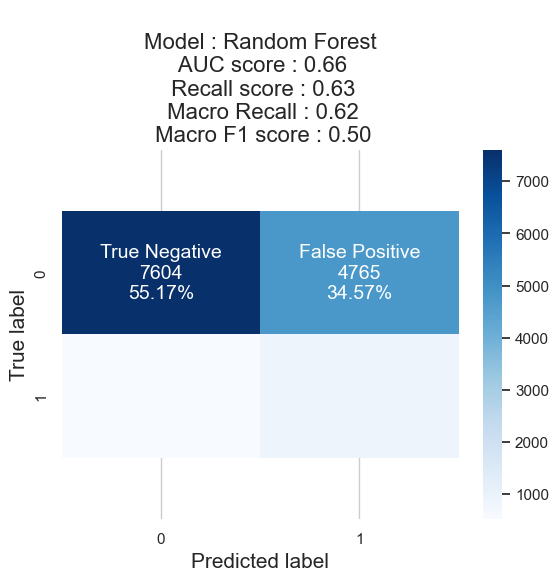

*************************************************



Fitting 10 folds for each of 5 candidates, totalling 50 fits


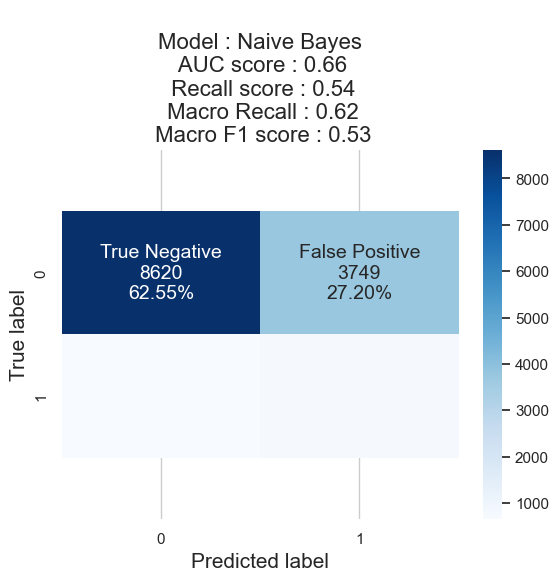

*************************************************



Fitting 5 folds for each of 5 candidates, totalling 25 fits


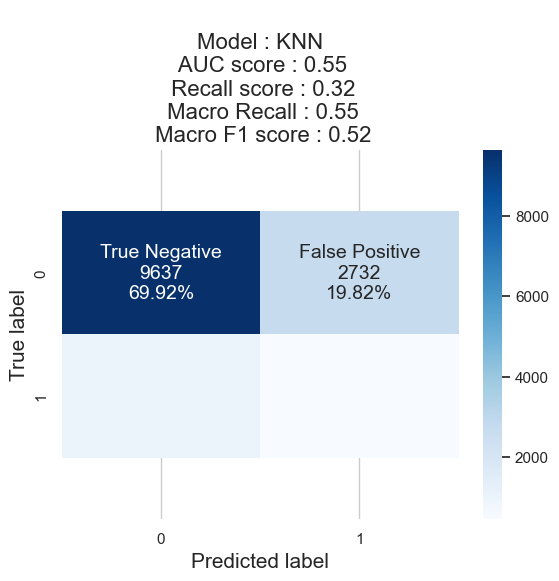

*************************************************





In [92]:
auc_list, recall_list, mac_recall_list, mac_f1_list, cf_list, model_names, model_list = find_best_model(X_tr,X_va,y_train,y_valid)

#### 2.3 Training and hyperparameter tuning for Boosting models

In [93]:
def boosting_models(X_train,X_valid,y_train,y_valid):
    """This function implements Boosting models namely XGBoost and AdaBoost with Decision tree as as base model
    
       Inputs : train and validation data
       Output : returns performance metrics of XGBoost and AdaBoost model
    """
    
    # Model 1 : XGBoost Classifier
    model_1 = XGBClassifier(seed=0, max_depth=5, scale_pos_weight=9, gamma=.1, learning_rate=.01)
    param_dict_1 = {'n_estimators': [500,600,700], 'min_child_weight':[7,8,9] }
    cv_model_1 = GridSearchCV(model_1,param_grid=param_dict_1, cv=5, n_jobs=-1,verbose=1,refit='roc_auc', 
                              scoring=['roc_auc', 'recall'] )
    cv_model_1.fit(X_train,y_train)
    auc_1, recall_1,mac_recall_1,mac_f1,cf_1 = score_calculations(X_valid,y_valid, cv_model_1)
    plot_confusion_matrix("XGBoost",auc_1,recall_1,mac_recall_1, mac_f1, cf_1)  
    
    # Model 2 : AdaBoost classifier
    DT = DecisionTreeClassifier(class_weight="balanced",max_depth=5,criterion="gini",  random_state=0)
    model_2 = AdaBoostClassifier(base_estimator=DT, random_state=0)
    param_dict_2 = { 'n_estimators': [300,400,500,600] }
    cv_model_2 = GridSearchCV(model_2,param_grid=param_dict_2, cv=5, n_jobs=-1,verbose=1,refit='roc_auc', 
                              scoring=['roc_auc', 'recall'] )
    cv_model_2.fit(X_train,y_train)
    auc_2, recall_2,mac_recall_2,mac_f2,cf_2 = score_calculations(X_valid,y_valid, cv_model_2)
    plot_confusion_matrix("AdaBoost Classifier",auc_2,recall_2,mac_recall_2,mac_f2,cf_2)    
    
    model_names = [ "XGBoost", 'AdaBoost']
    model_list = [cv_model_1, cv_model_2 ]
    auc_list = [auc_1, auc_2]
    recall_list = [ recall_1, recall_2 ]
    mac_recall_list = [mac_recall_1, mac_recall_2 ]
    mac_f1_list = [ mac_f1, mac_f2 ]
    cf_list = [cf_1,cf_2]
    return auc_list, recall_list, mac_recall_list, mac_f1_list, cf_list, model_names, model_list

Fitting 5 folds for each of 9 candidates, totalling 45 fits


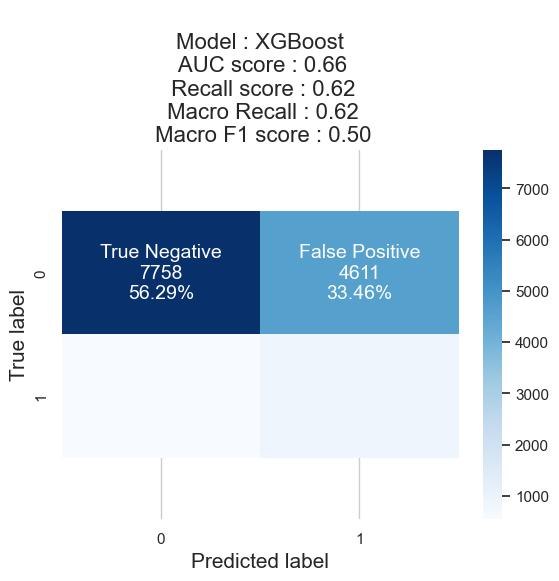

*************************************************



Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/anaconda3/lib/python3.11/

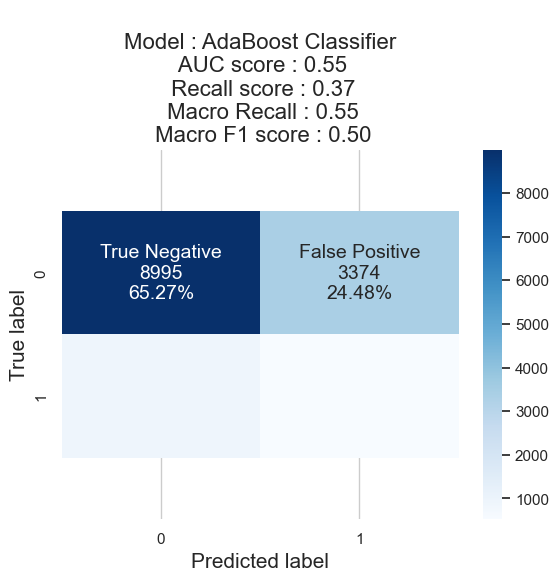

*************************************************





In [94]:
auc_list_1, recall_list_1, mac_recall_list_1, mac_f1_list_1, cf_list_1, model_names_1, model_list_1 = \
boosting_models(X_tr,X_va,y_train,y_valid)

#### 2.4 Custom Ensemble Model

In [95]:
def data_preparation(X,y):
    """This function takes in data and corresponding target variable. It then splits the data into train and test datasets
       Further, training dataset is splitted into D1 and D2 each 50% of original data 
       
       Input  : Dataset - X and y
       Output : D1,D2 and test dataset
    """
    # Train-test split 80-20
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)
    
    # Resetting index of train and test set
    X_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True,inplace=True)
    
    # randomly selecting 50% of total rows to create D1 
    rows_for_D1 = np.random.choice(int(X_train.shape[0]), size=int(X_train.shape[0]/2), replace=False)
    D1_X,D1_y = X_train.iloc[rows_for_D1 ],y_train[rows_for_D1] 
    
    # all datapoints in training dataset except those in D1 form D2
    rows_for_D2 = [ i for i in X_train.index if i not in rows_for_D1 ]
    D2_X,D2_y = X_train.iloc[rows_for_D2 ],y_train[rows_for_D2]
    
    return D1_X,D2_X,D1_y,D2_y,X_test,y_test

In [96]:
def test_Ensemble_model(models,meta_model, X_test, y_test, encoder): 
    """This function takes in the ensemble model and tests its performance on test dataset
    
       Input  : base models, ensemble model, Test dataset, one-hot encoder
       Output : prints confusion matrix and othe performance metrics. Returns performance metrics scores for test data.
    """
    # preparing test dataset
    X_test.reset_index(inplace=True, drop=True)
    X_test = X_test.astype(str)
    X_test = encoder.transform(X_test)
    predictions=[]
    
    # predictions made by base models
    for i in models : 
        predictions.append( i.predict(X_test) )
    
    meta_X = pd.DataFrame(predictions)
    meta_X = pd.DataFrame(meta_X.transpose().values)
    
    # calculate auc, binary recall, macro recall, macro f1 score and confusion matrix
    auc,binary_recall,macro_recall, macro_f1, cf = score_calculations(meta_X,y_test, meta_model)
    
    # plotting confusion matrix
    plot_confusion_matrix('Ensemble_model',auc,binary_recall,macro_recall, macro_f1, cf)
    
    return auc,binary_recall,macro_recall, macro_f1, cf

In [97]:
def Ensemble_model(X,y,sample_size):
    """This function implements custom Ensemble model. It is built as follows : 
       1. Splitting dataset into train and test set. 
       2. Splitting train dataset into two equal non-intersecting subsets - D1 and D2 
       3. Create k subsamples of D1 and build a base model for each subsampled dataset. Train these base models on 
          corresponding subsampled data of D1.
       4. Feed D2 data as the test data set to make predictions to all the base models. Horizontally concatenate all those
          predictions of k base models to create a new dataset, say meta-dataset. Use labels of D2 as its target variable
       5. Train meta-model on this meta-dataset
       6. Check the performance of this meta-model on test dataset by feeding test dataset to base models and then stackging
          the predictions of base models to create meta-dataset which will be input for meta-model. 
       7. This combination of base models and meta-model is out custom ensemble model
    
       Input  : Dataset and sample size
       Output : Performance metrics score of Ensemble model, base model and ensemble model
    """

    # Step 1 : Splitting dataset train and test set 
    # Step 2 : Splitting training data into D1 and D2 as non-intersecting subsets, each containing 50% of original dataset
    # function 'data_preparation' implements step 1 and step 2 and gives training and test set i.e. D1,D2 and Test set
    D1_X,D2_X,D1_y,D2_y,X_test,y_test = data_preparation(X,y)
    
    D1_X = D1_X.reset_index(drop=True)
    D2_X = D2_X.reset_index(drop=True)
    
    # converting all features to 'str' datatype for one hot encoding
    D1_X,D2_X = D1_X.astype(str), D2_X.astype(str)
    
    # OneHotEncoding data
    onehot = OneHotEncoder(handle_unknown='ignore', categories='auto')
    onehot.fit(D1_X)
    D1_X = onehot.transform(D1_X)
    D2_X = onehot.transform(D2_X)
    D1_X,D2_X = pd.DataFrame(D1_X.todense()), pd.DataFrame(D2_X.todense())
    
    samples_index, models,predictions,x_samples,y_samples = [],[],[],[],[]

    # Step 3 : Sampling with replacement to create 10 samples each of sample size 10000
    for i in range(10):
        # storing indices of all datapoints for each sample set
        samples_index.append( np.random.choice(D1_X.shape[0], size=sample_size, replace=True) )
        
        # creating sample set and appending it to list of samples set
        x_samples.append( D1_X.iloc[samples_index[-1]] )
        y_samples.append( D1_y[samples_index[-1]] )
        
        # creating base models for ensemble model  
        sample_model = DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=0)
        models.append(sample_model.fit(x_samples[-1],y_samples[-1]))
        
        # predicting labels for D2_X to create meta_dataset
        predictions.append(models[-1].predict(D2_X))
    
    # Step 4 : Creating meta_dataset with sampling models' predictions
    # creating meta dataset from predictions of base models
    meta_X = pd.DataFrame(predictions)
    meta_X = pd.DataFrame(meta_X.transpose().values)
    meta_y = D2_y
    
    # Step 5 : Building a meta model and training it on meta-dataset
    # defining meta model
    meta_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1, gpu_id=-1,verbosity=None,
              importance_type='gain', interaction_constraints='',subsample=1, tree_method='exact', validate_parameters=1,
              learning_rate=0.01, max_delta_step=0, max_depth=5,reg_alpha=0, reg_lambda=1, scale_pos_weight=9, seed=0,
              min_child_weight=8, n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0)
    # fitting data on meta model
    meta_model.fit(meta_X,meta_y)
    
    # Step 6 : Testing meta model on test dataset
    # function 'test_meta_model' evaluates ensemble model on the test dataset 
    auc,binary_recall,macro_recall, macro_f1, cf = test_Ensemble_model(models,meta_model, X_test, y_test, onehot)
    
    return auc,binary_recall,macro_recall, macro_f1, cf, models, meta_model

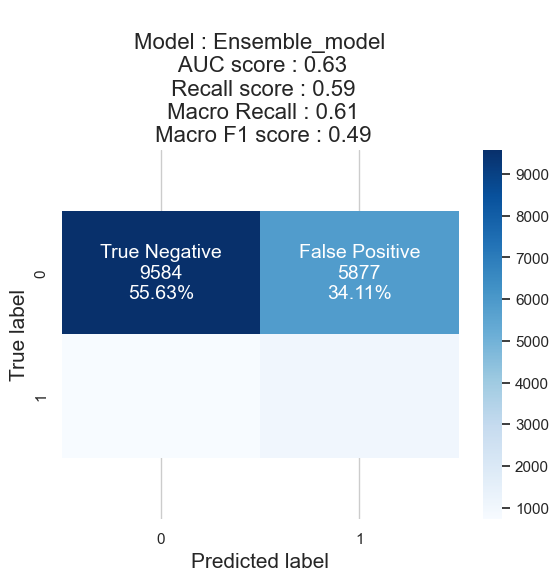

*************************************************





In [98]:
auc,binary_recall,macro_recall, macro_f1, cf, base_models, ensemble_model = Ensemble_model(X[features_list],y, 10000)

#### 2.5 Comparative study of ML models

As we can see, logistic regression outperformed all othe ML models in terms of both auc score and recall score. Let's plot them and check to confirm th e same. 

In [99]:
def plot_models_score_barplot(auc_list,recall_list,macro_recall, macro_f1, model_names):
    """This function takes in list of auc scores, recall scores and model names. It plots a join-bar char of auc scores and 
       recall scores
       
       input  : auc score list, recall score list, model names list
       output : returns nothing; plots bar chart
    """
    # Numbers of pairs of bars you want
    N = len(auc_list)
    # Data on X-axis
    # Specify the values of blue bars (height)
    blue_bar = auc_list
    # Specify the values of orange bars (height)
    orange_bar = recall_list
    # Specify the values of green bar
    green_bar = macro_recall
    # Specify the valeus of pink bar
    pink_bar = macro_f1
    # Position of bars on x-axis
    ind = np.arange(N)
    # Figure size
    plt.figure(figsize=(15,10))
    # Width of a bar 
    width = 0.2       
    # Plotting
    plt.bar(ind, blue_bar , width, label='AUC score')
    plt.bar(ind + width, orange_bar, width, label='Recall score')
    plt.bar(ind+ (2*width), green_bar, width, label = 'Macro Recall')
    plt.bar(ind+ (3*width), pink_bar, width, label = 'Macro F1')
    plt.xlabel('Machine learning models', fontsize=13)
    plt.ylabel('Scores', fontsize=13)
    plt.title('Comparative study of Machine Learning Models', fontsize=14)
    # xticks()
    # First argument - A list of positions at which ticks should be placed
    # Second argument -  A list of labels to place at the given locations
    plt.xticks(ind + width / 2,model_names, fontsize=13)
    # Finding the best position for legends and putting it
    plt.legend(loc='best', fontsize=13)
    plt.show()

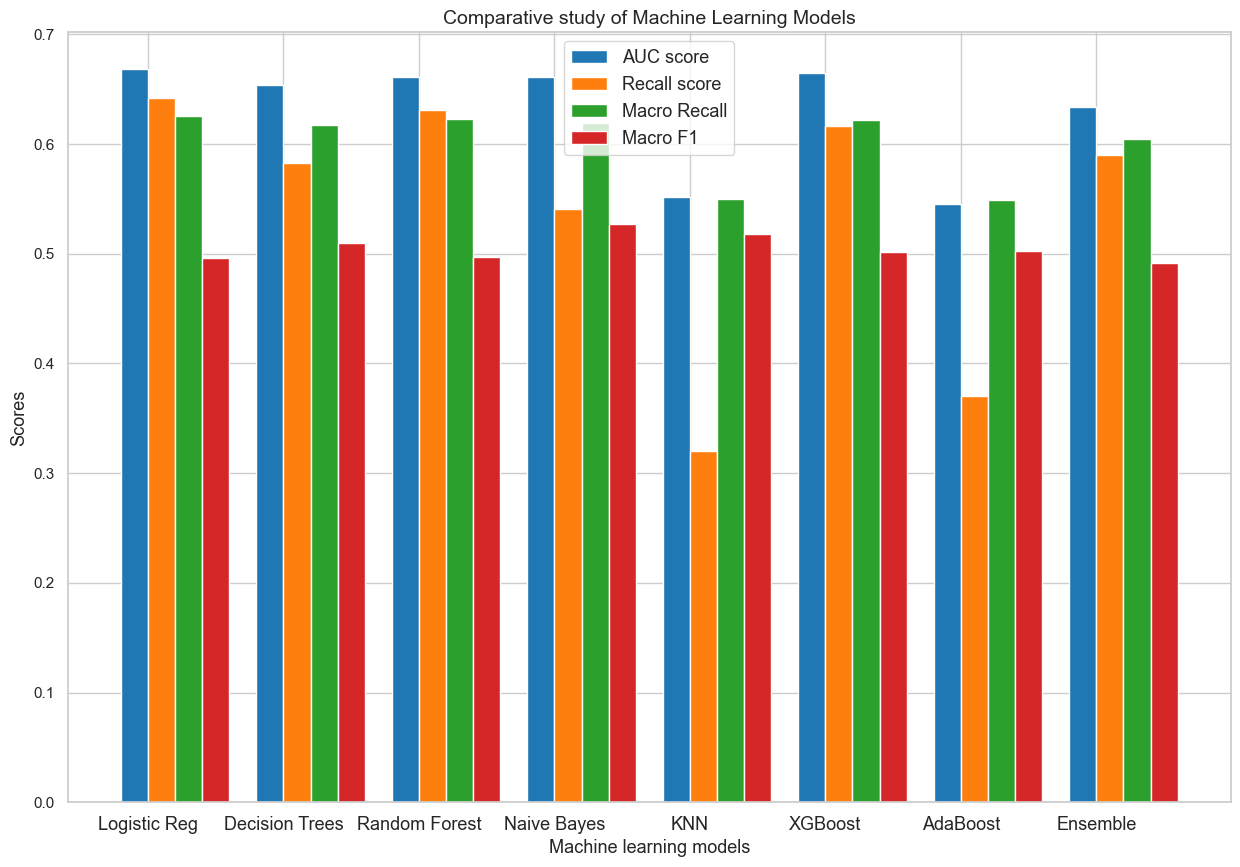

In [100]:
auc_list.extend(auc_list_1)
auc_list.append(auc)

recall_list.extend(recall_list_1)
recall_list.append(binary_recall)

mac_recall_list.extend(mac_recall_list_1)
mac_recall_list.append(macro_recall)

mac_f1_list.extend(mac_f1_list_1)
mac_f1_list.append(macro_f1)

model_names.extend(model_names_1)
model_names.append("Ensemble")

plot_models_score_barplot(auc_list,recall_list,mac_recall_list, mac_f1_list, model_names)

In [101]:
print(model_list[0].best_estimator_)
print(features_list)

SGDClassifier(alpha=0.001, class_weight='balanced', loss='log', random_state=0)
['discharge_disposition_id', 'number_inpatient', 'number_diagnoses', 'diabetesMed', 'diag_2', 'admission_source_id', 'A1Cresult', 'number_emergency']


XGBoost classifier and Logistic regression both are peroforming well, let's select Logistic Regression as it recall score is significantly higher than any othe model with auc in the same range as in Logistic regression.

### 3. Final model training and saving the same

Now, we have finalised the model i.e. Logistic Regression and the best selected features. Let's proceed to train our final model, test it's performance on test dataset and save the same for future evaluation. 

In [102]:
X_tr = X_train[features_list]
X_te = X_test[features_list]

# OneHotEncoding data
encoder = OneHotEncoder(handle_unknown='ignore', categories='auto')
encoder.fit(X_tr)
encoder_filename = 'OneHot_Encoder.sav'
pickle.dump(encoder, open(encoder_filename, 'wb'))
X_tr = encoder.transform(X_tr)
X_te = encoder.transform(X_te)

model = SGDClassifier(alpha=0.001, class_weight='balanced', loss='log', random_state=0)
model.fit(X_tr,y_train)
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))
auc,recall,mac_recall,mac_f1, cf = score_calculations(X_te,y_test, model)
print("Test AUC score is {:.2f}, Recall score is {:.2f}, macro recall is {:.2f}, macro f1 is {:.2f}".format(auc, recall, mac_recall, mac_f1))


Test AUC score is 0.65, Recall score is 0.61, macro recall is 0.61, macro f1 is 0.49


#### 3.1 Final function for Model deployment

In [103]:
def final(X_datapoint):
    """This function takes in query point and returns the predicted label ie. 1 if patient is likely to be readmitted and 0
       if patient is not likely to be readmitted. It also given the probability scores so that we know, how confident model
       is in determining the readmission status. 
       
       Input : query point
       output : label, probability scores
    """
    encoder = pickle.load(open('OneHot_Encoder.sav', 'rb'))
    X_datapoint = encoder.transform(X_datapoint.values.reshape(1,-1))
    model = pickle.load(open('finalized_model.sav', 'rb'))
    y = model.predict(X_datapoint)
    y_proba = model.predict_proba(X_datapoint)

    return y,y_proba 

# Testing on random points
temp_point = X_test[features_list]
y,y_proba = final(temp_point.iloc[5432])
print(y,y_proba)
y,y_proba = final(temp_point.iloc[7548])
print(y,y_proba)
y,y_proba = final(temp_point.iloc[8763])
print(y,y_proba)
y,y_proba = final(temp_point.iloc[6503])
print(y,y_proba)
y,y_proba = final(temp_point.iloc[5290])
print(y,y_proba)

[0] [[0.60086821 0.39913179]]
[0] [[0.50258273 0.49741727]]
[0] [[0.58591636 0.41408364]]
[0] [[0.51216654 0.48783346]]
[1] [[0.41800934 0.58199066]]
